# Model building and Routing

## Imports

In [2]:
import requests
import zipfile
import os
import pandas as pd
import ftplib
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
from pathlib import Path

## Get data for the model

In [4]:
# load the merged and preprocessed data
data = pd.read_csv("G:\AIMLDS\Projectss\Marine Route optimization\github\preprocessed_data.csv")

In [5]:
data

Unnamed: 0      EstimatedTime       LAT       LON  Heading  SOG_norm  \
0                0  23-01-01 00:00:00  28.28428 -79.63630      2.0  0.849515   
1                1  23-01-01 00:00:00  25.88697 -80.05251    182.0  0.092233   
2                3  23-01-01 00:00:00  24.02975 -81.70948     89.0  0.446602   
3                4  23-01-01 00:00:00  23.87015 -83.77240    104.0  0.432039   
4                5  23-01-01 00:00:00  32.66685 -78.33462    248.0  0.237864   
...            ...                ...       ...       ...      ...       ...   
305781      373403  23-04-01 23:01:00  25.51555 -79.53770    183.0  0.262136   
305782      373404  23-04-01 23:01:00  25.71019 -83.15791      1.0  0.150485   
305783      373405  23-04-01 23:01:00  29.39362 -80.81100    178.0  0.208738   
305784      373406  23-04-01 23:01:00  25.50736 -79.53787    183.0  0.262136   
305785      373407  23-04-01 23:01:00  24.23551 -81.77254     81.0  0.436893   

        COG_norm  GrossTonnage_norm  VHM0_norm  VMDR_norm  VTPK_norm  \
0       0.002222           0.490541   0.470990   0.369275   0.928495   
1       0.512222           0.014649   0.136519   0.486196   0.270011   
2       0.259167           0.245103   0.245734   0.340603   0.304162   
3       0.287500           0.564122   0.204778   0.455503   0.394877   
4       0.691667           0.358949   0.686007   0.625033   0.929562   
...          ...                ...        ...        ...        ...   
305781  0.502500           0.567973   0.133106   0.716368   0.382070   
305782  0.009444           0.210196   0.177474   0.764988   0.287086   
305783  0.499167           0.065629   0.290102   0.362679   0.940235   
305784  0.503333           0.567973   0.133106   0.716368   0.382070   
305785  0.220833           0.249121   0.204778   0.401777   0.316969   

        Temperature_norm  Salinity_norm  
0               0.922872       0.977493  
1               0.844779       0.977550  
2               0.962990       0.971043  
3               0.958419       0.975808  
4               0.869339       0.980886  
...                  ...            ...  
305781          0.931087       0.974290  
305782          0.849249       0.978398  
305783          0.689712       0.975270  
305784          0.931087       0.974290  
305785          0.929055       0.973751  

[305786 rows x 13 columns]

In [8]:
!pip install cartopy

  Obtaining dependency information for cartopy from https://files.pythonhosted.org/packages/bb/50/ab5495dcc22587179134cd37e6534212babeda78e86bda311c37c773f086/Cartopy-0.22.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for shapely>=1.7 from https://files.pythonhosted.org/packages/9e/39/029c441d8af32ab423b229c4525ce5ce6707318155b59634811a4c56f5c4/shapely-2.0.2-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/46.5 kB ? eta -:--:--
     -------------------------- ------------- 30.7/46.5 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 46.5/46.5 kB 1.2 MB/s eta 0:00:00
  Obtaining dependency information for pyproj>=3.1.0 from https://files.pythonhosted.org/packages/79/95/eb68113c5b5737c342bde1bab92705dabe69c16299c5a122616e50f1fbd6/pyproj-3.6.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/11.2 MB ? eta -:--:--
    --------------------------------------- 0.2/11.2 MB 4.6 MB/

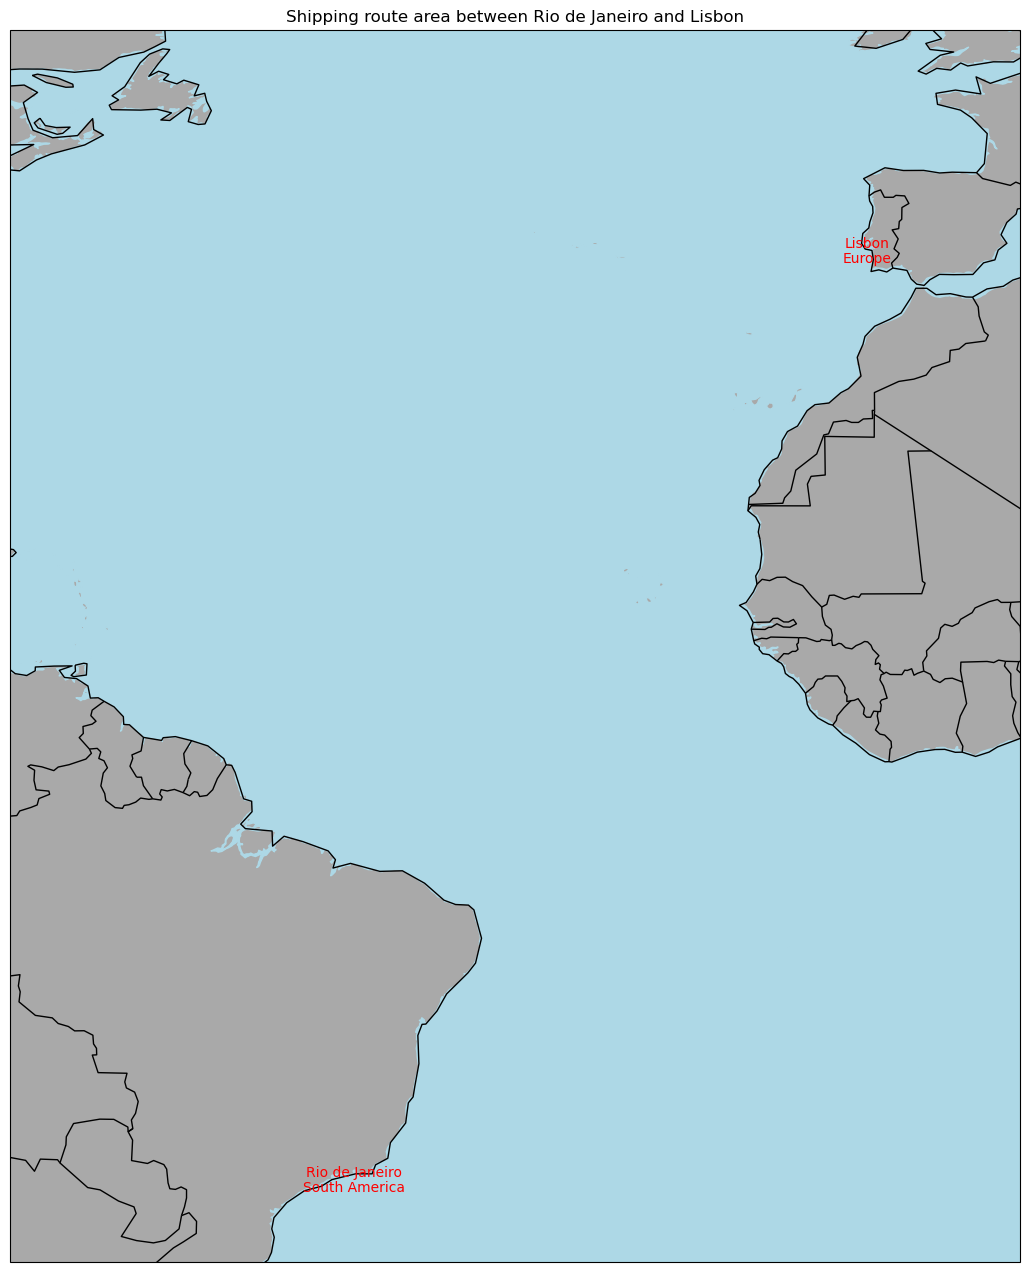

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the bounding box coordinates to cover Rio de Janeiro and Lisbon
bbox = ((1, -25), (-66, 48))

# Create a Matplotlib figure and axis with a specific Cartopy projection
fig, ax = plt.subplots(figsize=(20, 16), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features such as coastlines and borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

# Set the map extent based on the bounding box
ax.set_extent([bbox[0][0], bbox[1][0], bbox[0][1], bbox[1][1]])

# Add text labels for city names
label_properties = {
    'fontweight': 'normal',
    'fontsize': 10,
    'ha': 'center',
    'va': 'center',
}

# Define city labels with coordinates
labels = {
    'Rio de Janeiro': (-22.9083, -43.1964, 'South America', 'red'),
    'Lisbon': (38.7223, -9.1393, 'Europe', 'red'),
}

for city, (lat, lon, country, color) in labels.items():
    ax.text(lon, lat, city, color=color, **label_properties)
    ax.text(lon, lat - 1, country, color=color, **label_properties)

# Differentiate between land and ocean by setting colors
land = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='darkgrey')
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='lightblue')
ax.add_feature(land, zorder=0)
ax.add_feature(ocean, zorder=0)

# Add a title
plt.title("Shipping route area between Rio de Janeiro and Lisbon")

# Show the map
plt.show()


## Simple model: Linear regression

In [3]:
# Target variable
y = data.SOG_norm

# Predictors
features = ['VHM0_norm','VMDR_norm', 'VTPK_norm', 'Temperature_norm','Salinity_norm', 'Thickness_norm'] 
X = data[features]

# Split data to train and validation
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [4]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_X, train_y)

# Make predictions using the testing set
pred_y = regr.predict(val_X)

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(val_y, pred_y))
      
print('R^2: %.2f'
      % r2_score(val_y, pred_y))

Coefficients: 
 [0.09789246 0.02740957 0.0742894  0.14307844 0.06053226 0.02093163]
Mean squared error: 0.03
R^2: 0.05


## Advanced model: Random forest

In [5]:
my_file = Path('data/rf_model.joblib')

if my_file.is_file():
    forest_model = load('data/rf_model.joblib') 

else:
    forest_model = RandomForestRegressor(random_state = 1)
    forest_model.fit(train_X, train_y)
    pred_y = forest_model.predict(val_X)

    print('Mean squared error: %.2f'
          % mean_squared_error(val_y, pred_y))

    print('R^2: %.2f'
          % r2_score(val_y, pred_y))

    dump(forest_model, 'data/rf_model.joblib') 

# Add variable importance
feature_importance_values = forest_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

R^2 of Random forest: 0.89

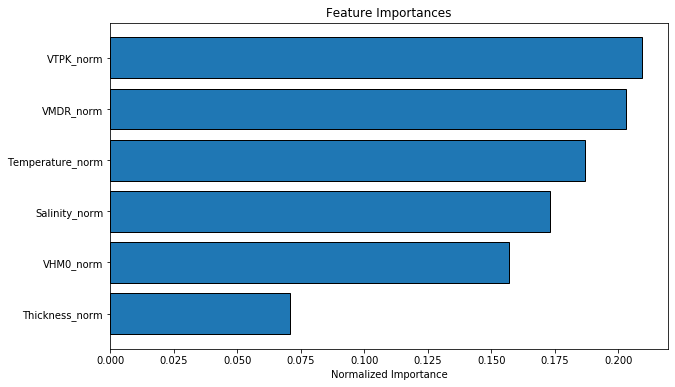

In [6]:
def plot_feature_importances(df):
    
    """Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called 'importance'
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# Routing

## Get forecast data for the routing

- 2021-06-01
- 2021-06-02
- 2021-06-03

In [7]:
wav_all = xr.open_mfdataset('data/routing/mf*.nc')
phy_all = xr.open_mfdataset('data/routing/me*.nc')

## Area of interest

Calculate the optimal shipping route between Lisbon and Rio de Janeiro considering wave and weather forecasts.

Lisbon: 38.716666° N 9.1667° W

Rio de Janeiro: 22.908333° S 43.196389° W

In [8]:
# Get array index to the value that is closest to a given value
def get_closest(array, value):
    return np.abs(array - value).argmin()

In [9]:
# Set bounding box for the allowed routing corridor
bbox = ((-45, -25),(-7, 41))

In [10]:
# Get indices of the bbox
lon_min = get_closest(wav_all.longitude.data, bbox[0][0])
lat_min = get_closest(wav_all.latitude.data, bbox[0][1])
lon_max = get_closest(wav_all.longitude.data, bbox[1][0])
lat_max = get_closest(wav_all.latitude.data, bbox[1][1])

## Simple solution: Calculate optimal route with weights for one day

- 2021-06-01

In [11]:
# Define first common time (12:00:00)
time_slice_wav = 3
time_slice_phy = 0
# Extract array from dataset to define the cost in the routing algorithm 
# Wave height
wave_height = wav_all.VHM0.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave direction
wave_dir = wav_all.VMDR.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave period
wave_per = wav_all.VTPK.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Temperature
temp = phy_all.thetao.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Salinity
sal = phy_all.so.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Thickness
thi = phy_all.mlotst.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

### Start and end point of the route

In [12]:
lat_Lis = 38.716666
lon_Lis = -9.1667
lat_Rio = -22.908333
lon_Rio = -43.196389

In [13]:
# compute great_circle distance @see: https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97

from math import radians, degrees, sin, cos, asin, acos, sqrt
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

print("Distance between Lisbon and Rio in m: ",great_circle(lon_Lis,lat_Lis, lon_Rio, lat_Rio))

Distance between Lisbon and Rio in m:  7714.762847516416


In [14]:
start_lon = get_closest(wave_height.longitude.data, lon_Lis)
start_lat = get_closest(wave_height.latitude.data, lat_Lis)
end_lon = get_closest(wave_height.longitude.data,lon_Rio)
end_lat = get_closest(wave_height.latitude.data,lat_Rio)

In [15]:
start = (start_lat, start_lon)
end = (end_lat, end_lon)

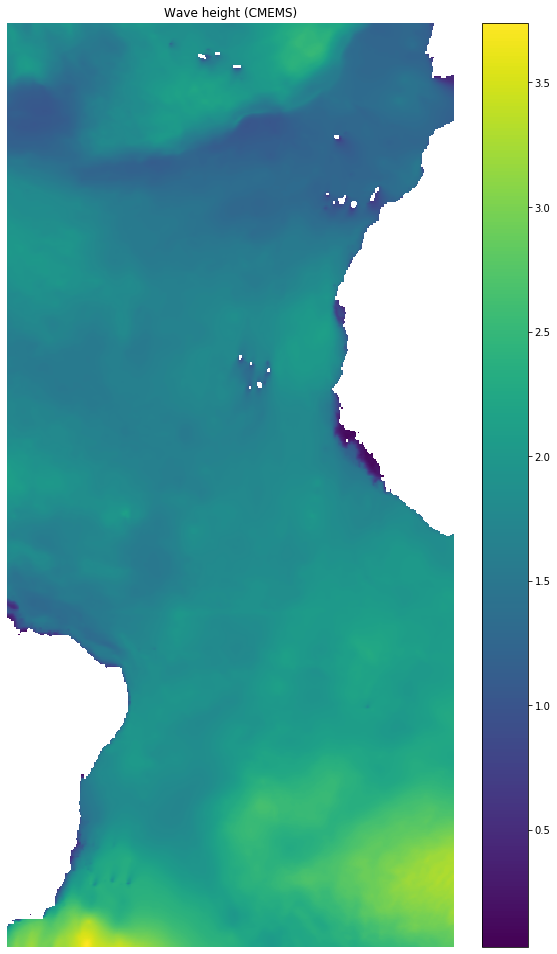

In [16]:
# Plot wave height as an example variable
plt.figure(figsize=(10,17))

# Costs
plt.imshow(wave_height.data, aspect='auto')

plt.title("Wave height (CMEMS)")
plt.colorbar()
plt.axis("off")
plt.gca().invert_yaxis()

In [17]:
# Mask land areas
land_mask = wave_height.data.copy() 
land_mask[np.isnan(land_mask)] = 1
land_mask[land_mask != 1] = 0

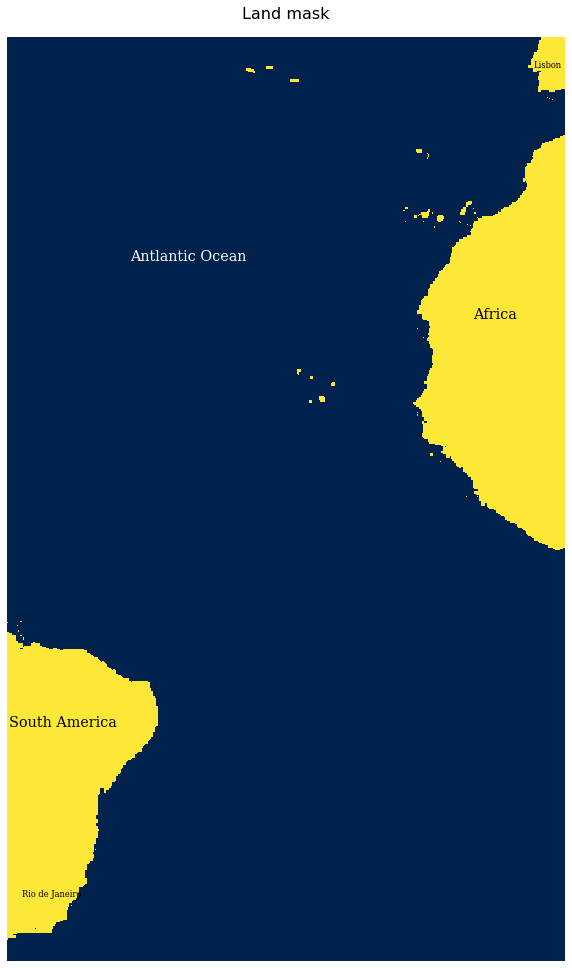

In [18]:
# Plot optimal route
plt.figure(figsize=(10,17))

plt.imshow(land_mask, aspect='auto', cmap = 'cividis')
plt.text(start[1],start[0], 'Lisbon', color = 'black', fontfamily = 'serif', fontsize = 'small')
plt.text(end[1]-10,end[0]+30, 'Rio de Janeiro', color = 'black', fontfamily = 'serif', fontsize = 'small')
plt.text(100, 600, 'Antlantic Ocean', color = 'white', fontfamily = 'serif', fontsize = 'x-large')
plt.text(1, 200, 'South America', color = 'black', fontfamily = 'serif', fontsize = 'x-large')
plt.text(380, 550, 'Africa', color = 'black', fontfamily = 'serif', fontsize = 'x-large')
plt.title('Land mask', fontsize = 16, pad = 18)
plt.axis("off")
plt.gca().invert_yaxis()

### Get variable costs

In [19]:
# Assign data directly as costs
wh_costs = wave_height.data
wd_costs = wave_dir.data
wp_costs = wave_per.data
temp_costs = temp.data
sal_costs = sal.data
thi_costs = thi.data

In [20]:
def stand_and_norm (x): 
    """Returns the standardized and normalized array."""
    # Standardization
    x_stand = (x - np.nanmean(x)) / np.nanstd(x)

    # Normalization
    x_norm = (x_stand - np.nanmin(x_stand)) / (np.nanmax(x_stand) - np.nanmin(x_stand))

    # Check for na values and assign them with maximum values
    if(np.any(np.isnan(x_norm))):
        x_norm[np.isnan(x_norm)] = 1 

    return x_norm

In [21]:
wh_costs = stand_and_norm(wh_costs)
wd_costs = stand_and_norm(wd_costs)
wp_costs = stand_and_norm(wp_costs)
temp_costs = stand_and_norm(temp_costs)
sal_costs = stand_and_norm(sal_costs)
thi_costs = stand_and_norm(thi_costs)

### Calulate costs based on linear regression model

In [22]:
# Get regression coefficients
rc = regr.coef_

# Weight are taken from linear regression model
speed = rc[0]*wh_costs + rc[1]*wd_costs + rc[2]*wp_costs + rc[3]*temp_costs + rc[4]*sal_costs + rc[5]*thi_costs

# invert costs, because costs imitate speed 
inverted_speed = -1*speed + np.abs(np.max(speed))

In [23]:
wh_costs[land_mask == 1] = 1
inverted_speed[land_mask == 1] = 1

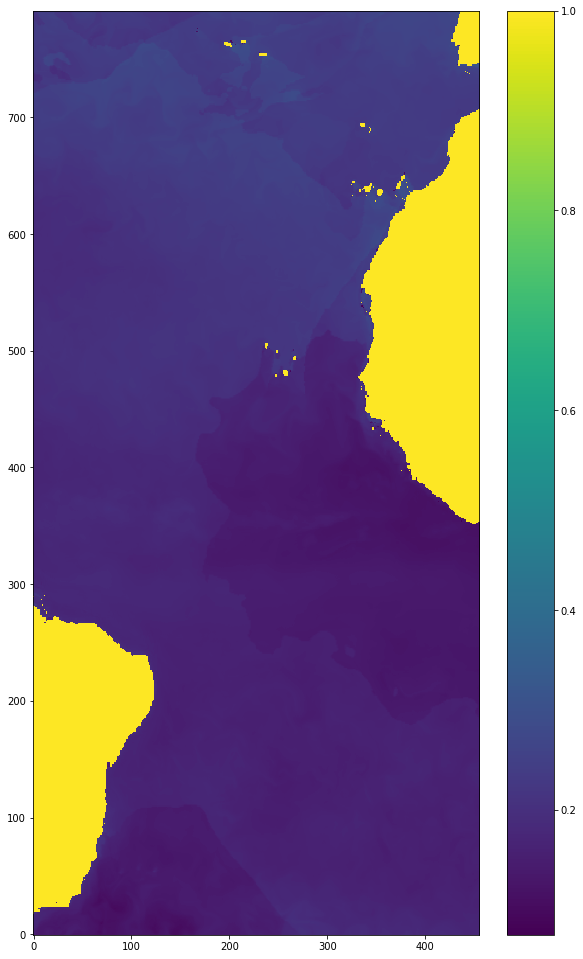

In [24]:
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(inverted_speed, aspect='auto')
plt.colorbar()
plt.gca().invert_yaxis()

In [25]:
inverted_speed = inverted_speed.compute()

In [26]:
from skimage.graph import route_through_array

# Calculate optimal route based on the minimum cost path

# Optional parameters:
# - fully_connected 
#     - False -> only axial moves are allowed
#     - True  -> diagonal moves are allowed
# - geometric 
#     - False -> minimum cost path
#     - True  -> distance-weighted minimum cost path

wh_indices, weight = route_through_array(wh_costs, start, end, fully_connected=True, geometric=True)
wh_indices = np.stack(wh_indices, axis=-1)

wd_indices, weight = route_through_array(wd_costs, start, end, fully_connected=True, geometric=True)
wd_indices = np.stack(wd_indices, axis=-1)

wp_indices, weight = route_through_array(wp_costs, start, end, fully_connected=True, geometric=True)
wp_indices = np.stack(wp_indices, axis=-1)

temp_indices, weight = route_through_array(temp_costs, start, end, fully_connected=True, geometric=True)
temp_indices = np.stack(temp_indices, axis=-1)

sal_indices, weight = route_through_array(sal_costs, start, end, fully_connected=True, geometric=True)
sal_indices = np.stack(sal_indices, axis=-1)

thi_indices, weight = route_through_array(thi_costs, start, end, fully_connected=True, geometric=True)
thi_indices = np.stack(thi_indices, axis=-1)

merged_indices, weight_lr = route_through_array(inverted_speed, start, end, fully_connected=True, geometric=True)
merged_indices = np.stack(merged_indices, axis=-1)


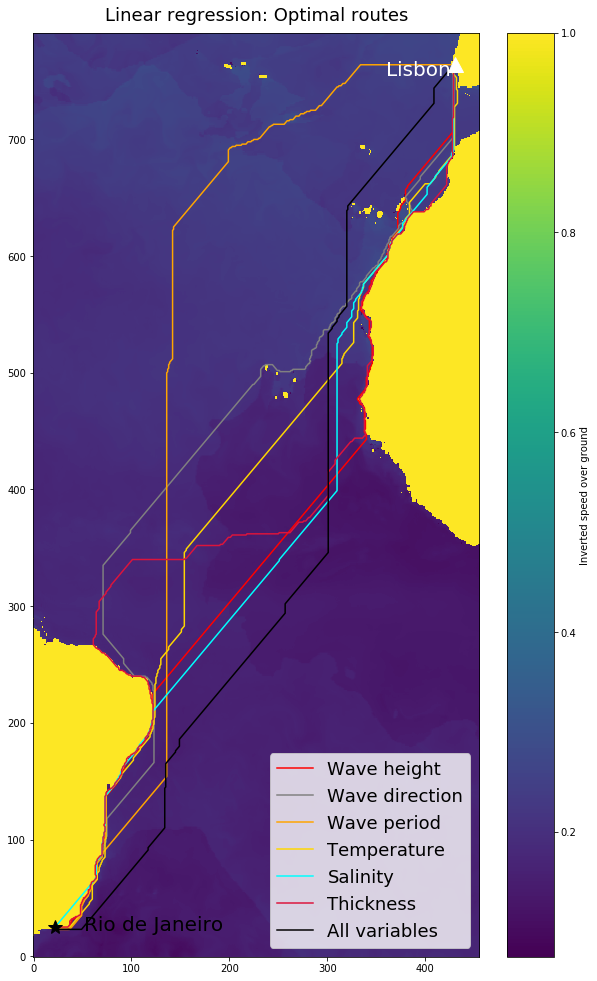

In [27]:
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(inverted_speed, aspect='auto')

# Routes
plt.plot(wh_indices[1], wh_indices[0], 'red', label = 'Wave height')
plt.plot(wd_indices[1], wd_indices[0], 'grey', label = 'Wave direction')
plt.plot(wp_indices[1], wp_indices[0], 'orange', label = 'Wave period')
plt.plot(temp_indices[1], temp_indices[0], 'gold', label = 'Temperature')
plt.plot(sal_indices[1], sal_indices[0], 'cyan', label = 'Salinity')
plt.plot(thi_indices[1], thi_indices[0], 'crimson', label = 'Thickness')
plt.plot(merged_indices[1], merged_indices[0], 'black', label = 'All variables')

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = 'white')
plt.text(start_lon - 70, start_lat - 10, 'Lisbon', fontsize = 20, color = 'white')
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 30, end_lat - 3, 'Rio de Janeiro', fontsize = 20)
plt.title('Linear regression: Optimal routes', fontsize = 18, pad = 12)
plt.colorbar(label='Inverted speed over ground')
plt.legend(loc = "lower right", prop={'size': 18})
plt.gca().invert_yaxis()

### Calulate costs based on random forest model

In [28]:
# Reshape 2d array to dataframes to apply the random forest
wave_height_1d = pd.DataFrame(data = wh_costs.compute().ravel())
wave_dir_1d = pd.DataFrame(data = wd_costs.compute().ravel())
wave_per_1d = pd.DataFrame(data = wp_costs.compute().ravel())
temp_1d = pd.DataFrame(data = temp_costs.compute().ravel())
sal_1d = pd.DataFrame(data = sal_costs.compute().ravel())
thi_1d = pd.DataFrame(data = thi_costs.compute().ravel())

concat_costs = pd.concat([wave_height_1d, wave_dir_1d, wave_per_1d, temp_1d, sal_1d, thi_1d], axis = 1)
concat_costs.columns = ['Wave height', 'Wave direction', 'Wave period', 'Temperature', 'Salinity', 'Thickness']

for_pred = forest_model.predict(concat_costs)

In [29]:
# Invert costs, because costs imitate speed 
inverted_speed_forest = -1 * for_pred + np.abs(np.max(for_pred))

In [30]:
# Reshape speed costs to get back the map
wave_height_np = wh_costs.compute()

map_shape = wave_height_np.shape

rf_speed = np.reshape(inverted_speed_forest, map_shape)

In [31]:
# Assign non-water areas high values
rf_speed[land_mask ==1] = 1 

In [32]:
# Compute route
# Distance weighted minimum cost path
rf_indices, weight_simple_day_one = route_through_array(rf_speed, start, end, fully_connected=True, geometric=True)
rf_indices = np.stack(rf_indices, axis=-1)

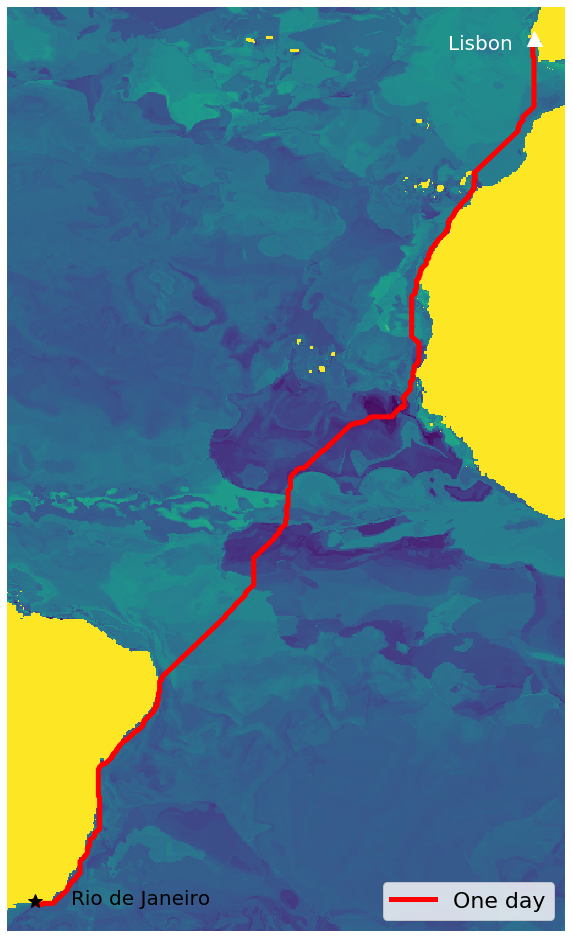

In [33]:
# Presentation plot simple solution
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(rf_speed, aspect='auto')

plt.plot(rf_indices[1],rf_indices[0], 'red', label = 'One day', lw = 5)

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = 'white')
plt.text(start_lon - 70, start_lat - 10, 'Lisbon', fontsize = 20, color = 'white')
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 30, end_lat - 3, 'Rio de Janeiro', fontsize = 20)
#plt.title('Simple solution (one day)', fontsize = 18, pad = 12)
plt.legend(loc = 'lower right', prop={'size': 22})
# plt.colorbar(label='Inverted speed over ground')
plt.axis('off')
plt.gca().invert_yaxis()

## Advanced solution: Calculate optimal route based on *multiple* variables and *multiple* days

In [34]:
# Show times for WAV
time = phy_all.sel(time=~phy_all.get_index('time').duplicated()).time

rows = []

for step in range(time.size):
    
    time_df_phy = str(time.values[step])
    rows.append([step, time_df_phy])

time_df_phy = pd.DataFrame(rows, columns = ['Step', 'Time'])

In [35]:
# Show times for PHY
time = wav_all.sel(time=~wav_all.get_index('time').duplicated()).time

rows = []

for step in range(time.size):
    
    time_df_wav = str(time.values[step])
    rows.append([step, time_df_wav])

time_df_wav = pd.DataFrame(rows, columns = ['Step', 'Time'])

In [36]:
# Get the times that exist in both datasets (12:00:00 for the three days)
common_time = np.intersect1d(time_df_wav['Time'], time_df_phy['Time'])

# Create arrays with the corresponding steps - For waves forecast: [3, 11, 19, 27] & For physics forecast: [0, 1, 2, 3]
time_wav = []
time_phy = []

for t in range(common_time.size):
    time_wav.append(int(time_df_wav['Step'].loc[time_df_wav['Time'] == common_time[t]]))
    time_phy.append(int(time_df_phy['Step'].loc[time_df_phy['Time'] == common_time[t]]))

# Create time slices (start, end, step)
step_wav = time_wav[1] - time_wav[0]
time_slice_wav = slice(min(time_wav), max(time_wav) + 1, step_wav)
step_phy = time_phy[1] - time_phy[0]
time_slice_phy = slice(min(time_phy), max(time_phy) + 1, step_phy)

In [37]:
# Extract array from dataset to define the cost in the routing algorithm with a new time_slice
# Wave height
wave_height_3day = wav_all.VHM0.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave direction
wave_dir_3day = wav_all.VMDR.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave period
wave_per_3day = wav_all.VTPK.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Temperature
temp_3day = phy_all.thetao.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Salinity
sal_3day = phy_all.so.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Thickness
thi_3day = phy_all.mlotst.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

In [38]:
wh_costs_3d = wave_height_3day.data.compute()
wd_costs_3d = wave_dir_3day.data.compute()
wp_costs_3d = wave_per_3day.data.compute()
te_costs_3d = temp_3day.data.compute()
sa_costs_3d = sal_3day.data.compute()
th_costs_3d = thi_3day.data.compute()

In [39]:
# standardize each time slice (day)
for i in range (np.shape(wave_height_3day)[0]):
    wh_costs_3d[i] = stand_and_norm(wh_costs_3d[i])
    wd_costs_3d[i] = stand_and_norm(wd_costs_3d[i])
    wp_costs_3d[i] = stand_and_norm(wp_costs_3d[i])
    te_costs_3d[i] = stand_and_norm(te_costs_3d[i])
    sa_costs_3d[i] = stand_and_norm(sa_costs_3d[i])
    th_costs_3d[i] = stand_and_norm(th_costs_3d[i])

In [40]:
# reshape 2d array to dataframes to apply the random forest
wave_height_1d = pd.DataFrame(data = wh_costs_3d.flatten())
wave_dir_1d = pd.DataFrame(data = wd_costs_3d.flatten())
wave_per_1d = pd.DataFrame(data = wp_costs_3d.flatten())
temp_1d = pd.DataFrame(data = te_costs_3d.flatten())
sal_1d = pd.DataFrame(data = sa_costs_3d.flatten())
thi_1d = pd.DataFrame(data = th_costs_3d.flatten())

concat_costs = pd.concat([wave_height_1d, wave_dir_1d, wave_per_1d, temp_1d, sal_1d, thi_1d], axis = 1)
concat_costs.columns = ['Wave height', 'Wave direction', 'Wave period', 'Temperature', 'Salinity', 'Thickness']

# Predict speed using random forest model
costs = forest_model.predict(concat_costs)

In [41]:
# Reshape speed costs to get back the map
costs = np.reshape(costs,wh_costs_3d.shape)

In [42]:
# Sum costs for all timesteps
costs_all_times_mean = (costs[0] + costs[1] + costs[2])/3

In [43]:
# Assign non-water areas high values
costs_all_times_mean[land_mask ==1] = 1

In [44]:
# Get data for a specific timestep
costs_day_1 = costs[0]
costs_day_2 = costs[1]
costs_day_3 = costs[2]

In [45]:
# Assign max values for land areas
costs_day_1[land_mask == 1] = 1
costs_day_2[land_mask == 1] = 1
costs_day_3[land_mask == 1] = 1

In [46]:
# Distance weighted minimum cost path (dw-mcp)

# Calculate optimal route for all days
merged_indices_all_times, weight_all_times = route_through_array(costs_all_times_mean, start, end, fully_connected=True, geometric=True)
merged_indices_all_times = np.stack(merged_indices_all_times, axis=-1)

# Calculate optimal route for day one
merged_indices_day_one, weight_day_one = route_through_array(costs_day_1, start, end, fully_connected=True, geometric=True)
merged_indices_day_one = np.stack(merged_indices_day_one, axis=-1)

# Calculate optimal route for day two
merged_indices_day_two, weight = route_through_array(costs_day_2, start, end, fully_connected=True, geometric=True)
merged_indices_day_two = np.stack(merged_indices_day_two, axis=-1)

# Calculate optimal route for day three
merged_indices_day_three, weight = route_through_array(costs_day_3, start, end, fully_connected=True, geometric=True)
merged_indices_day_three = np.stack(merged_indices_day_three, axis=-1)

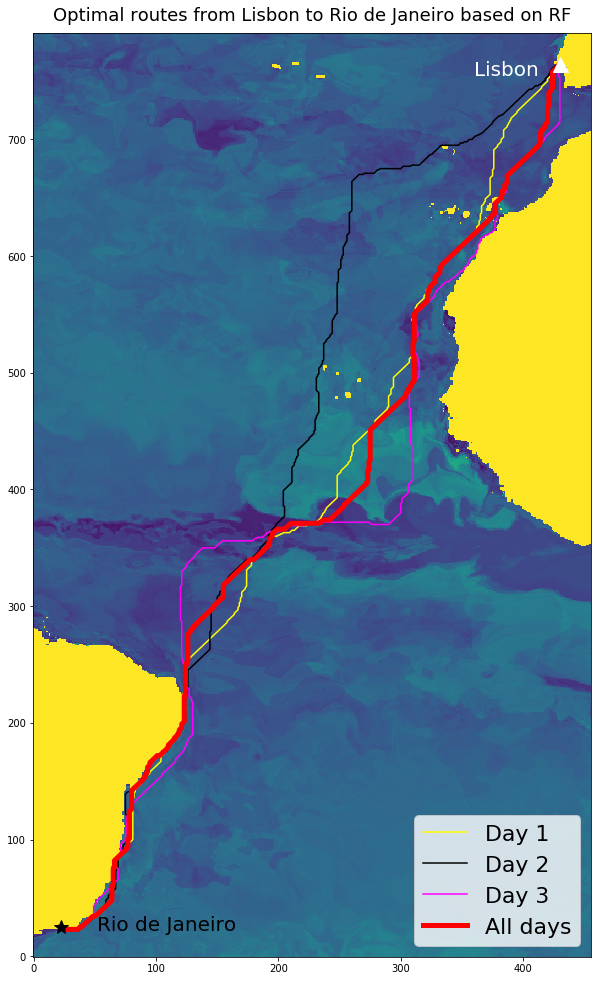

In [47]:
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(costs_all_times_mean, aspect='auto')

# Routes
plt.plot(merged_indices_day_one[1], merged_indices_day_one[0], 'yellow', label = 'Day 1')
plt.plot(merged_indices_day_two[1], merged_indices_day_two[0], 'black', label = 'Day 2')
plt.plot(merged_indices_day_three[1], merged_indices_day_three[0], 'magenta', label = 'Day 3')
plt.plot(merged_indices_all_times[1], merged_indices_all_times[0], 'red', label = "All days", lw = 5)

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = 'white')
plt.text(start_lon - 70, start_lat - 10, 'Lisbon', fontsize = 20, color = 'white')
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 30, end_lat - 3, 'Rio de Janeiro', fontsize = 20)
plt.title('Optimal routes from Lisbon to Rio de Janeiro based on RF', fontsize = 18, pad = 12)
# plt.colorbar(label = 'Inverted speed over ground all days')
plt.legend(loc = 'lower right', prop={'size': 22})
plt.gca().invert_yaxis()

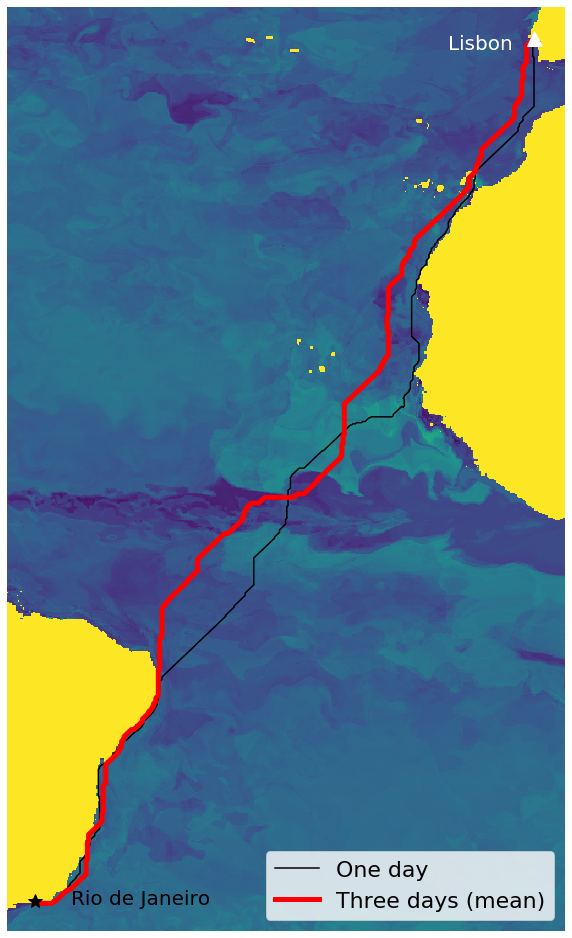

In [48]:
# Presentation plot intermediate solution distance-weighted minimum cost path
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(costs_all_times_mean, aspect='auto')

# Routes
plt.plot(rf_indices[1], rf_indices[0], 'black', label = 'One day')
plt.plot(merged_indices_all_times[1], merged_indices_all_times[0], 'red', label = "Three days (mean)", lw = 5)

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = 'white')
plt.text(start_lon - 70, start_lat - 10, 'Lisbon', fontsize = 20, color = 'white')
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 30, end_lat - 3, 'Rio de Janeiro', fontsize = 20)
#plt.title('Intermediate solution (mean)', fontsize = 18, pad = 12)
#plt.colorbar(label = 'Inverted speed over ground all days')
plt.legend(loc = 'lower right', prop={'size': 22})
plt.axis('off')
plt.gca().invert_yaxis()

## Advanced solution (costs separated)

In [49]:
# Find indices that can be reached within one day
# @see: https://stackoverflow.com/questions/52920499/find-all-points-within-distance-1-of-specific-point-in-2d-numpy-matrix
# Set up matrix
day_all_mask = np.zeros(map_shape)

# Convert to python scalars
r = start[0]
c = start[1]
# Get boundaries of array
m, n = day_all_mask.shape

# Set this value to a distance that the ship can reach within one day
dist_per_day = 300

# Loop over possible locations
for i in range(0-r,m): 
    for j in range(0-c,n): 
        # Check if location is within boundary
        if (0 <= r + i < m and 0 <= c + j < n):
            if np.linalg.norm([r+i,c+j] - np.array(start))<dist_per_day:
                day_all_mask[r+i,c+j] = 1
            elif (np.linalg.norm([r+i,c+j] - np.array(start))>=dist_per_day and 
                  np.linalg.norm([r+i,c+j] - np.array(start))<2*dist_per_day):
                day_all_mask[r+i,c+j] = 2
            else:
                day_all_mask[r+i,c+j] = 3

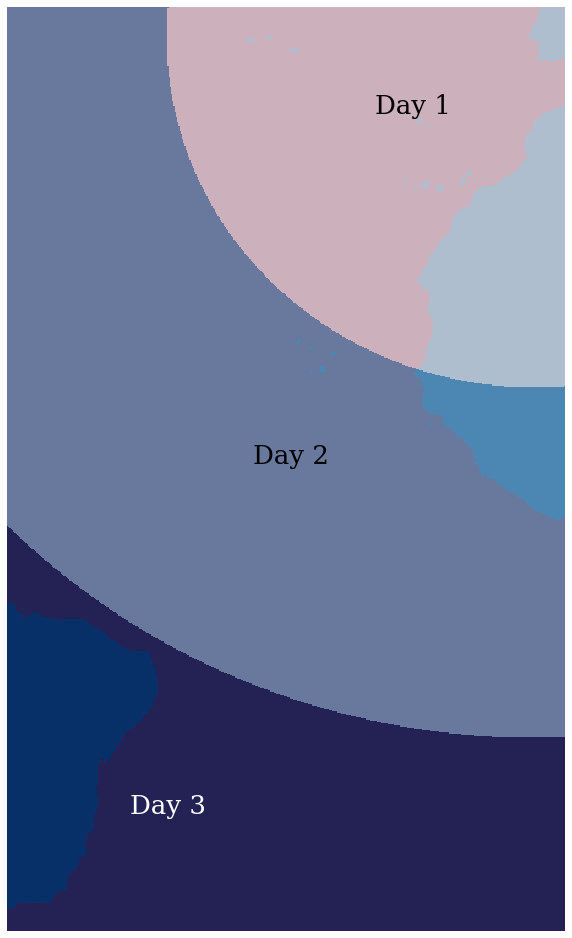

In [50]:
# Plot cost splitting
plt.figure(figsize=(10,17))

plt.text(300, 700, 'Day 1', color = 'black', fontfamily = 'serif', fontsize = 26)
plt.text(200, 400, 'Day 2', color = 'black', fontfamily = 'serif', fontsize = 26)
plt.text(100, 100, 'Day 3', color = 'white', fontfamily = 'serif', fontsize = 26)

# Costs
plt.imshow(day_all_mask, aspect = 'auto',cmap="Blues")
plt.imshow(land_mask, aspect='auto', cmap = 'RdBu', alpha=0.3)
# plt.title('Costs separation', fontsize = 16, pad = 18)
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [51]:
costs_ecd = np.zeros(map_shape) # ecd = euclidean distance

In [52]:
costs_ecd[day_all_mask == 1] = costs[0][day_all_mask == 1]
costs_ecd[day_all_mask == 2] = costs[1][day_all_mask == 2]
costs_ecd[day_all_mask == 3] = costs[2][day_all_mask == 3]

In [53]:
# Calculate optimal route for all days distance-weighted minimum cost path
indices_ecd_costs, weight_ecd = route_through_array(costs_ecd, start, end, fully_connected=True, geometric=True)
indices_ecd_costs = np.stack(indices_ecd_costs, axis=-1)

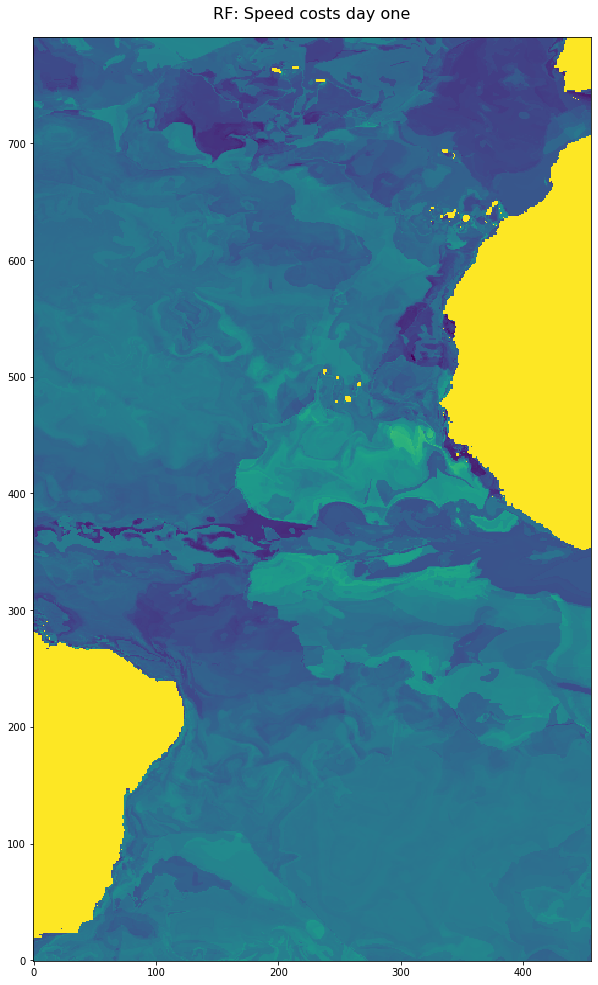

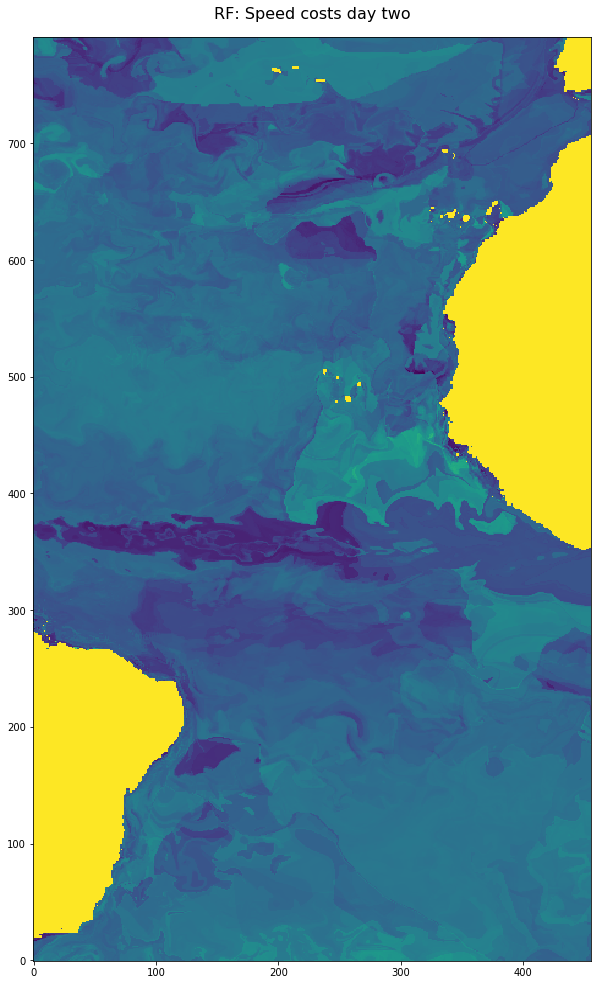

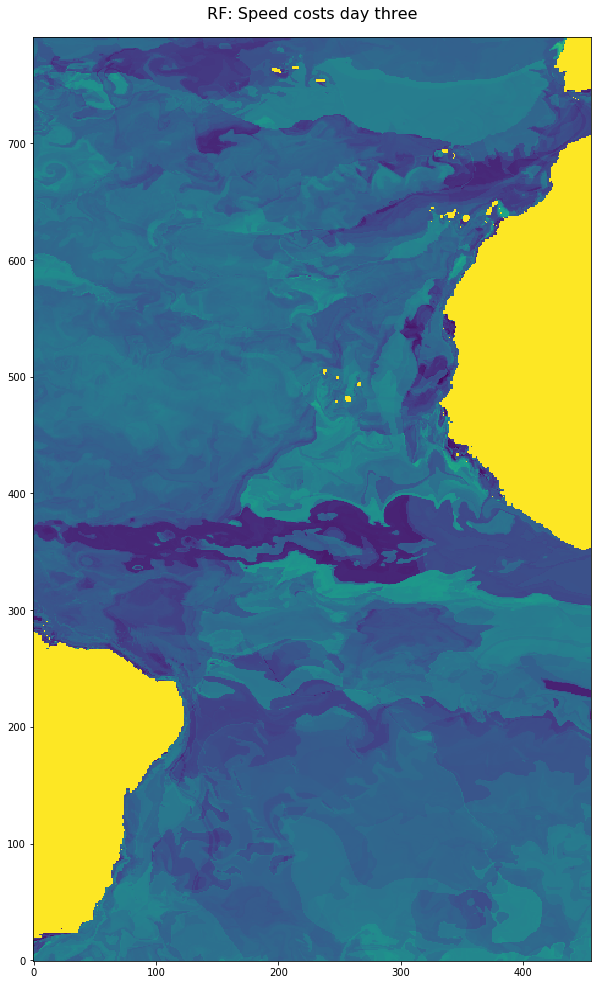

In [54]:
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(costs[0], aspect='auto')
plt.title("RF: Speed costs day one", fontsize = 16, pad = 18)
# plt.axis('off')
plt.gca().invert_yaxis()

plt.figure(figsize=(10,17))
plt.imshow(costs[1], aspect='auto')
plt.title("RF: Speed costs day two", fontsize = 16, pad = 18)
plt.gca().invert_yaxis()

plt.figure(figsize=(10,17))
plt.imshow(costs[2], aspect='auto')
plt.title("RF: Speed costs day three", fontsize = 16, pad = 18)
plt.gca().invert_yaxis()

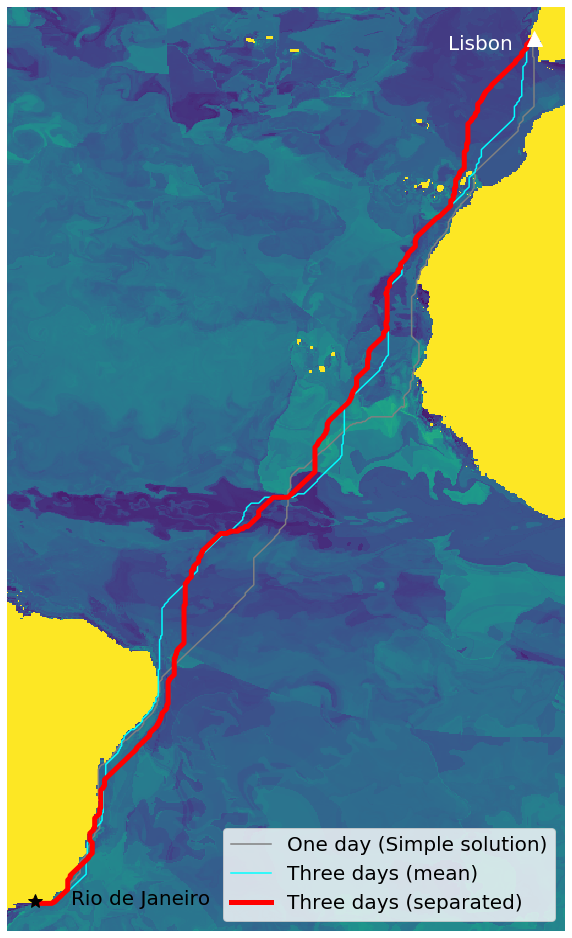

In [55]:
# Plot optimal routes with minimum cost path
plt.figure(figsize=(10,17))

# Costs
plt.imshow(costs_ecd, aspect='auto')

plt.plot(rf_indices[1], rf_indices[0], 'grey', label = 'One day (Simple solution)')
plt.plot(merged_indices_all_times[1], merged_indices_all_times[0], 'cyan', label = 'Three days (mean)')
plt.plot(indices_ecd_costs[1],indices_ecd_costs[0], 'red', label = 'Three days (separated)', lw = 5)

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = 'white')
plt.text(start_lon - 70, start_lat - 10, 'Lisbon', fontsize = 20, color = 'white')
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 30, end_lat - 3, 'Rio de Janeiro', fontsize = 20)
# plt.title('Advanced solution (split)', fontsize = 18, pad = 12)
plt.legend(loc = 'lower right', prop={'size': 20})
#plt.colorbar(label = 'Inverted speed over ground')
plt.axis('off')
plt.gca().invert_yaxis()

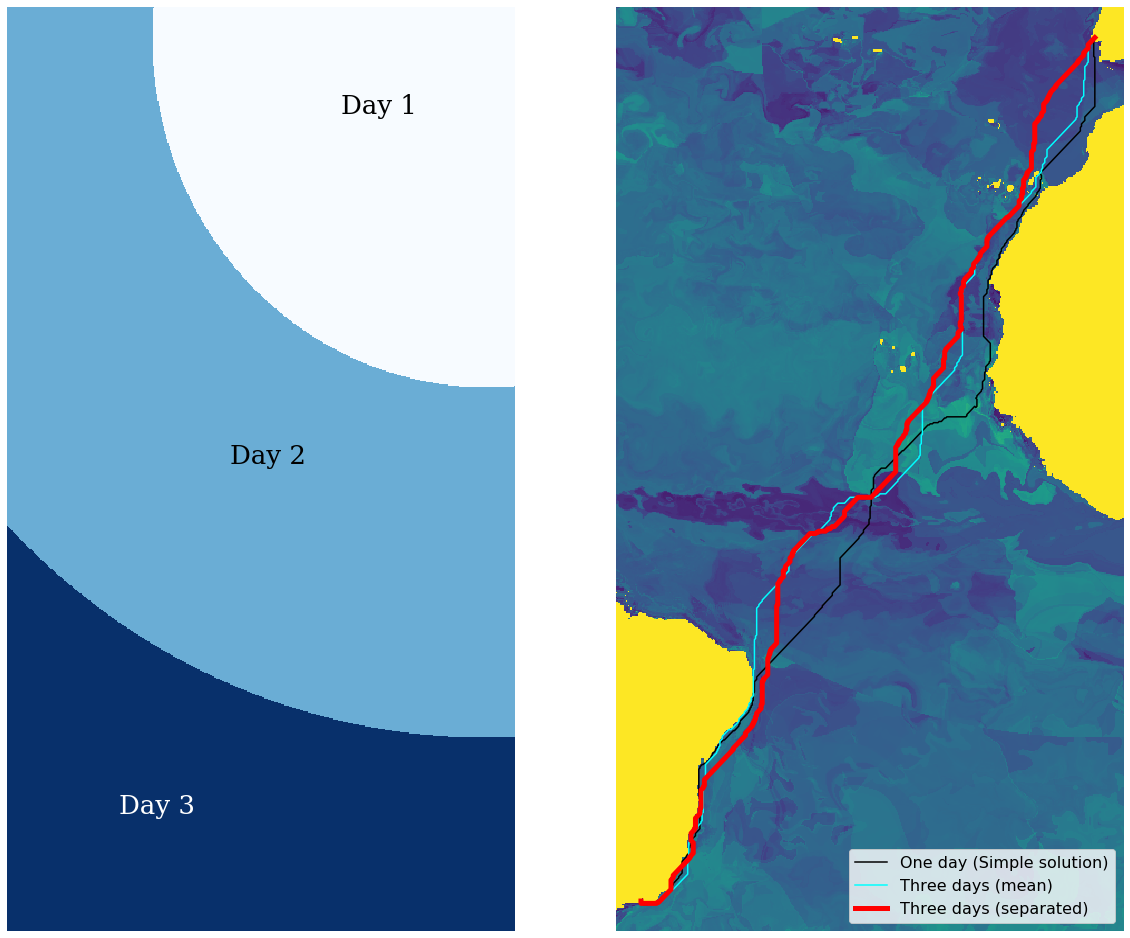

In [56]:
# Plot and compare fastest routes
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(20,17))

# Costs
ax1.imshow(costs_ecd, aspect='auto')

ax1.plot(rf_indices[1], rf_indices[0], 'black', label = 'One day (Simple solution)')
ax1.plot(merged_indices_all_times[1], merged_indices_all_times[0], 'cyan', label = 'Three days (mean)')
ax1.plot(indices_ecd_costs[1],indices_ecd_costs[0], 'red', label = 'Three days (separated)', lw = 5)


# Costs
ax2.imshow(day_all_mask, aspect = 'auto',cmap="Blues")

ax2.text(300, 700, 'Day 1', color = 'black', fontfamily = 'serif', fontsize = 26)
ax2.text(200, 400, 'Day 2', color = 'black', fontfamily = 'serif', fontsize = 26)
ax2.text(100, 100, 'Day 3', color = 'white', fontfamily = 'serif', fontsize = 26)

# ax1.set_title('Route comparison', fontsize = 18, pad = 12)
# ax2.set_title('Areas for cost separation', fontsize = 18, pad = 12)
ax1.legend(loc = 'lower right', prop={'size': 16})

ax1.axis('off')
ax2.axis('off')
ax1.invert_yaxis()
ax2.invert_yaxis()

In [57]:
# Compute total costs
# relative to each other; weight_day_one = 1
print("\nTotal costs compared to Simple Solution: ")
# Just one day (day 1)
print("One day Simple solution: ", weight_simple_day_one/weight_simple_day_one)
# Mean of all days
print("All days mean: ", weight_all_times/weight_simple_day_one)
# Multiple days 
print("All days splitted: ", weight_ecd/weight_simple_day_one)


Total costs compared to Simple Solution: 
One day Simple solution:  1.0
All days mean:  1.0646950242380102
All days splitted:  0.9486024897459013


# Cost comparison relative to one day solution
| One day (RF)| All days mean (RF)| All days splitted (RF)|
| ----------- | ----------- | ----------- |
| 1 | 1.06 | 0.95 |


-> 5% faster splitting the route costs instead of using just one day

### References
* https://levelup.gitconnected.com/dijkstras-shortest-path-algorithm-in-a-grid-eb505eb3a290